# Flowers Image Classification by InceptionV3

## Загрузка библиотек

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, utils, datasets, models
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [5]:
from glob import glob
from PIL import Image
import random

Установка seed, для повторяемости результатов

In [6]:
def seed_everything(seed=656461256):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

Устройство для запуска модели (cuda или cpu)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Загрузка модели и ее настройка

In [8]:
# Pre-trained Inception v3 model. Image classification model, loaded with weights pre-trained on ImageNet
inception = models.inception_v3(pretrained=True)

# Замораживание параметром модели
for param in inception.parameters():
    param.requires_grad = False

# Установка 5-ти выходных классов
num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs, 5)

# Подключение модели к устройсву
inception = inception.to(device)

C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Трансформатор изображения

In [9]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Функции для обучения и валидирования модели

In [12]:
def train(model, optimizer, train_loader, val_loader, n_epoch, device):
    result = []
    val_res = []

    criterion = nn.CrossEntropyLoss()
    for e in range(n_epoch):
        model.train()
        correct, total_loss = 0, 0
        total = 0
        
        for sample, target in train_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            optimizer.zero_grad()
            outputs, aux_outputs = model(sample)
            loss1 = criterion(outputs, target)
            loss2 = criterion(aux_outputs, target)
            loss = loss1 + 0.4*loss2  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        acc_train = 100 * correct / total
        val_acc = valid(model, val_loader, device)
        print(f'Epoch: [{e+1}/{n_epoch}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        
        result.append(acc_train)
        val_res.append(val_acc)
    
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array(val_res), fmt='%.2f', delimiter=',')


In [13]:
def valid(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample, target in val_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            outputs = model(sample)
            _, predicted = torch.max(outputs.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total
    return val_accuracy


In [14]:
def plot():
    train_data = np.loadtxt('result.csv', delimiter=',')
    val_data = np.loadtxt('val_result.csv', delimiter=',')
    plt.figure()
    plt.plot(range(1, len(train_data) + 1), train_data, color='blue', label='Train')
    plt.plot(range(1, len(val_data) + 1), val_data, color='red', label='Validation')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Validation Accuracy', fontsize=16)
    plt.savefig('plot.png')
    plt.show() 

## Загрузка тестовых и валидационных данных

Использовался Dataset: https://www.kaggle.com/datasets/alsaniipe/flowers-multiclass-datasets/data

In [10]:
train_data = datasets.ImageFolder(root='dataset/flower_photos/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [11]:
val_data = datasets.ImageFolder(root='dataset/flower_photos/validation', transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

## Запуск обучения

Epoch: [1/10], Loss: 0.1449, Train Acc: 57.63, Val Acc: 77.50
Epoch: [2/10], Loss: 0.1313, Train Acc: 77.99, Val Acc: 83.75
Epoch: [3/10], Loss: 0.1272, Train Acc: 80.62, Val Acc: 88.75
Epoch: [4/10], Loss: 0.1249, Train Acc: 82.01, Val Acc: 87.50
Epoch: [5/10], Loss: 0.1238, Train Acc: 83.19, Val Acc: 87.50
Epoch: [6/10], Loss: 0.1227, Train Acc: 84.18, Val Acc: 88.75
Epoch: [7/10], Loss: 0.1221, Train Acc: 84.52, Val Acc: 91.25
Epoch: [8/10], Loss: 0.1221, Train Acc: 84.18, Val Acc: 91.25
Epoch: [9/10], Loss: 0.1211, Train Acc: 85.25, Val Acc: 90.00
Epoch: [10/10], Loss: 0.1209, Train Acc: 85.51, Val Acc: 91.25


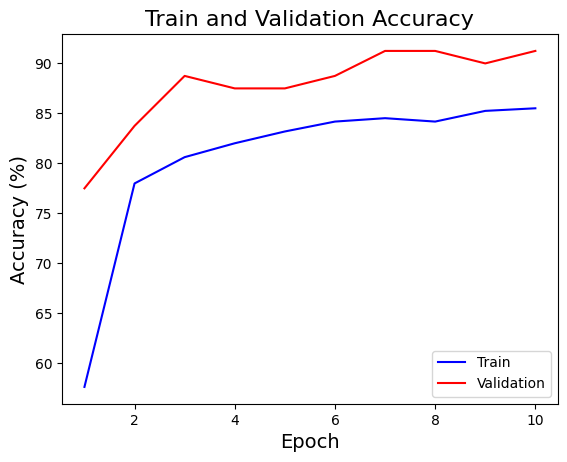

In [15]:
optimizer = optim.SGD(inception.fc.parameters(), lr=0.001, momentum=0.9)
train(inception, optimizer, train_loader, val_loader, n_epoch=10, device=device)
plot()

# Testing

In [16]:
test_data = datasets.ImageFolder(root='dataset/flower_photos/test' , transform=transform) 
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

images, targets = next(iter(test_dataloader))  
indices = np.arange(len(images))
np.random.shuffle(indices)

int_to_label = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
result = []

for i, idx in enumerate(indices):
    image = images[idx]
    actual_target = targets[idx]
    image_tensor = image.to(device).unsqueeze(0)
    output = inception(image_tensor)
    _, prediction = torch.max(output, 1)

    prediction_class = prediction.cpu().item()
    actual_class = actual_target.item()
    
    result.append({
        'expected': actual_class, 
        'actual': prediction_class, 
        'filename': test_data.imgs[idx]
    })


In [17]:
df = pd.DataFrame(data=result)

df['expected_label'] = df['expected'].map(lambda x: int_to_label[x])
df['actual_label'] = df['actual'].map(lambda x: int_to_label[x])
df['correctly'] = df['expected'] == df['actual']

# Вычисляем точность модели
accuracy = accuracy_score(df['expected'], df['actual'])

print(f"\nWe have test accuracy {accuracy * 100:.4f}% after test images evaluation.")

df.head()


We have test accuracy 80.0000% after test images evaluation.


,expected,actual,filename,expected_label,actual_label,correctly
0,0,0,(dataset/flower_photos/test\daisy\538920244_59...,daisy,daisy,True
1,0,0,(dataset/flower_photos/test\daisy\19813618946_...,daisy,daisy,True
2,3,3,(dataset/flower_photos/test\sunflowers\2097286...,sunflowers,sunflowers,True
3,3,3,(dataset/flower_photos/test\sunflowers\2097286...,sunflowers,sunflowers,True
4,1,1,(dataset/flower_photos/test\dandelion\57406338...,dandelion,dandelion,True
